In [1]:
import time
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (auc, roc_curve, accuracy_score, 
                             confusion_matrix, precision_score, f1_score, 
                             recall_score, ConfusionMatrixDisplay, roc_auc_score, classification_report)
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_csv('../dataset/m_dataset.csv')
dataset.head(2)

,event_name,search,added_to_cart,removed_from_cart,begin_checkout,browser,page_path,city,day_of_week,device_category,...,screen_width,screen_height,direct,organic_search,organic_social,referral,android,ios,macintosh,windows
0,4,5,4,0,0,1,21,29,7,1,...,360,820,0,0,0,1,1,0,0,0
1,4,9,1,1,0,1,21,29,2,1,...,360,800,0,0,0,1,1,0,0,0


# MODELING START BELOW

In [3]:
start_time = time.time()
# spliting of dataset 
X = dataset.drop('signup', axis=1)
y = dataset['signup']

# splitting the store dataset into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.3)


# define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200,300,500],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None,'sqrt','log2']
}

# Initialize the random forest classifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Perform random search cross-validation
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=10,
    cv=5,
    error_score='raise'
)

random_search.fit(X_train, y_train)

# Get the best model and its hyperparameters
best_model = random_search.best_estimator_
best_params = random_search.best_params_

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# feature importance 
f_imp = best_model.feature_importances_

end_time = time.time()
duration = end_time - start_time

print("Best Model Hyperparameters:", best_params)

print("Accuracy:", round(accuracy,2))

# Calculate precision
precision = precision_score(y_test, y_pred)
print("Precision:", round(precision,2))

# Calculate recall
recall = recall_score(y_test, y_pred)
print("Recall:", round(recall,2))

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 score:", round(f1,2))

# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred)
print("AUC-ROC:", round(auc_roc,2))


print(f"Execution time in seconds {duration}")

Best Model Hyperparameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': None}
Accuracy: 0.81
Precision: 0.79
Recall: 0.79
F1 score: 0.79
AUC-ROC: 0.81
Execution time in seconds 85.33911490440369


In [4]:
# Get the feature name and importance to the model sorted in descending

# Create a list of tuples containing feature names and importance values
f_imp_list = [(feature_name, importance) for feature_name, importance in zip(X_train.columns, f_imp)]

# Sort the feature importances list in descending order of importance values
sorted_f_imp = sorted(f_imp_list, key=lambda x: x[1], reverse=True)

# Print the features in descending order of importance
for feature_name, importance in sorted_f_imp:
    print(f"{feature_name}: {round(importance, 4)}")


page_path: 0.1784
event_name: 0.0925
screen_height: 0.0919
day_of_week: 0.0902
search: 0.0811
city: 0.0587
added_to_cart: 0.0545
removed_from_cart: 0.044
screen_width: 0.0392
events_per_session: 0.0371
views: 0.037
event_count_per_user: 0.0357
user_engagement: 0.0196
begin_checkout: 0.0192
session: 0.0178
browser: 0.0155
organic_search: 0.0149
direct: 0.0146
engagement_rate: 0.0119
referral: 0.0104
engaged_session: 0.0096
ios: 0.0082
android: 0.0068
device_category: 0.0046
windows: 0.0035
macintosh: 0.0018
organic_social: 0.0015


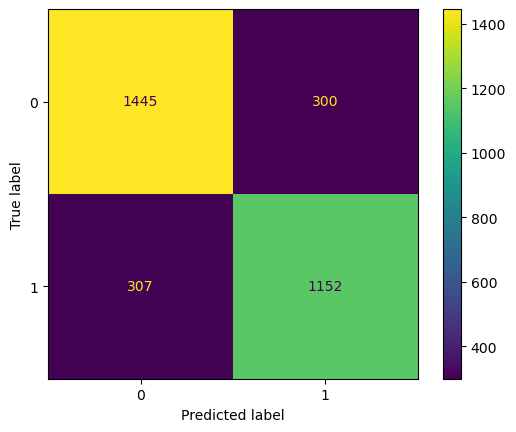

In [5]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

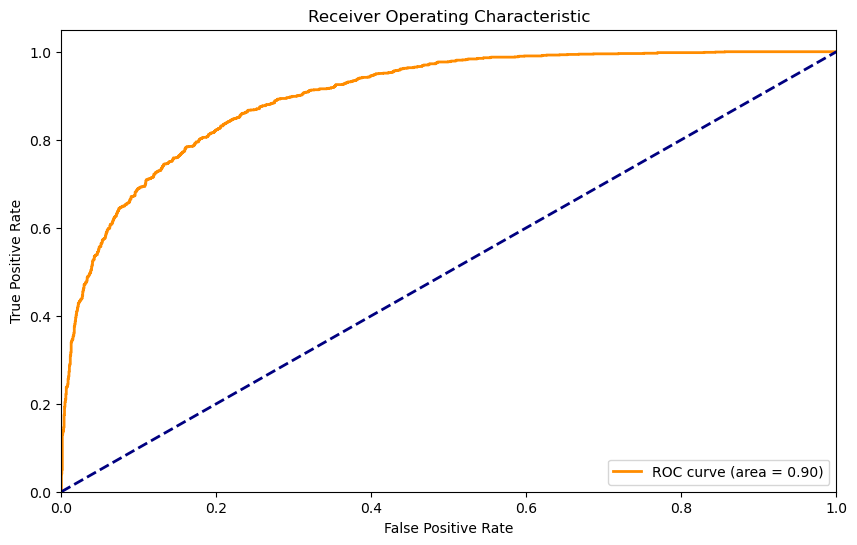

In [6]:
# Assuming best_model is the best model obtained from hyperparameter tuning
# best_model = random_search.best_estimator_

# Get the predicted probabilities for the positive class
y_score = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()